In [ ]:
from collections import deque
from constants import * # import API_KEY
from pyspark import SparkContext
import requests
from time import time

# Change the color of the output
CRED  = '\033[31m'
CGREEN = '\033[32m'
CYELLOW = '\033[33m'
CEND  = '\033[0m'  # revert to default color
# Start PySpark
sc.stop() # stop any existing contexts
sc = SparkContext.getOrCreate()
BASE_API = "https://api.themoviedb.org/3"
# Make the movie list a deque so that up to 10 recommended movies can show and older movies can be dequeued
movie_list = deque(maxlen=10)

# Dictionary of genre ids -> genre names (gotten from endpoint /genre/movie/list)
GENRES = {
  28: "Action",
  12: "Adventure",
  16: "Animation",
  35: "Comedy",
  80: "Crime",
  99: "Documentary",
  18: "Drama",
  10751: "Family",
  14: "Fantasy",
  36: "History",
  27: "Horror",
  10402: "Music",
  9648: "Mystery",
  10749: "Romance",
  878: "Science Fiction",
  10770: "TV Movie",
  53: "Thriller",
  10752: "War",
  37: "Western"
}

def show_movies(req, movies):
    # Show error if the movies can't be shown (return false to indicate error)
    if req.status_code != 200:
        code = movies.get("status_code", "???")
        message = movies.get("status_message", "Unknown error, oh no!")
        print(f"{CRED}Error {code}: {message}{CEND}")
        return False
    elif movies["total_results"] == 0:
        print(f"{CRED}No results found.{CEND}")
        return False
    
    # Limit to the first 10 results
    print("Top 10 results:")
    for index, result in enumerate(movies["results"][:10]):
        # Add placeholders to any missing fields
        title = result.get("title", "no title")
        release_date = result.get("release_date", "no release date")
        stars = result.get("vote_average", "-")
        overview = result.get("overview", "no description available")
        print(f"{index + 1}. {CGREEN}{title} {CRED}({release_date}) {CYELLOW}({stars} \u2605){CEND}\n{overview}\n")
    
    return True

def update_watchlist(movies, num_movies=10):
    # Ask the user if they want to add movies to their watchlist
    print("Which movies interest you?")
    movie_choices = input("Enter the numbers in the list separated by a space (e.g. 1 2 3): ").split()
    
    # Add the id of the movie to the movie list for future GET requests
    for index in movie_choices:
        try:
            movie_index = int(index)
            
            if movie_index >= 1 and movie_index <= num_movies:
                movie = movies["results"][movie_index - 1]
                movie_list.append(movie["id"])
                print(f"{CGREEN}Added {movie['title']} to your watchlist{CEND}")
        except ValueError:
            continue # ignore any invalid inputs

def search_by_name():
    # /search/movie
    movie_query = input("Which movie would you like to see? ")
    
    if not movie_query:
        return # can't run an empty query

    # Search for a movie from TMDb
    req = requests.get(f"{BASE_API}/search/movie?api_key={API_KEY}&query={movie_query}")
    movies = req.json()
    
    if show_movies(req, movies):
        update_watchlist(movies)

def search_by_year():
    #/discover/movie?primary release year =
    movie_year_query = input("Which year would you like to see a movie from? ")
    
    if not movie_year_query:
        return # can't run an empty query

    # Search for a movie from TMDb
    req = requests.get(f"{BASE_API}/discover/movie?api_key={API_KEY}&primary_release_year={movie_year_query}")
    movies = req.json()
    
    if show_movies(req, movies):
        update_watchlist(movies)

def search_by_ratings():
    #/discover/movie?vote_average.gte=
    movie_rating_query = input("What minimum rating for movies would you like to see from 1 (bad) to 10 (good)? ")
    
    if not movie_rating_query:
        return # can't run an empty query

    # Search for a movie from TMDb
    req = requests.get(f"{BASE_API}/discover/movie?api_key={API_KEY}&vote_average.gte={movie_rating_query}")
    movies = req.json()
    
    if show_movies(req, movies):
        update_watchlist(movies)

def search_by_genre():
    # /discover/movie?with_genres=
    print(f"List of genres:\n{GENRES}")
    genre_id = 0
    
    # Get a valid genre id from the user
    while GENRES.get(genre_id) is None and genre_id != -1:
        try:
            genre_id = int(input("Please select a genre number (or -1 to exit): "))
            
            if GENRES.get(genre_id) is None and genre_id != -1:
                print(f"{CRED}That's not a valid genre id, try again{CEND}")
        except ValueError:
            print(f"{CRED}That's not an integer, try again{CEND}")
    
    if genre_id == -1:
        return # -1 = go back to the main menu
    
    # Search movies given the genre id (sort by popularity in descending order)
    req = requests.get(
        f"{BASE_API}/discover/movie?api_key={API_KEY}&with_genres={genre_id}&sort_by=popularity.desc")
    movies = req.json()
    
    if show_movies(req, movies):
        update_watchlist(movies)

def popular_movies():
    # /movie/popular
    req = requests.get(f"{BASE_API}/movie/popular?api_key={API_KEY}")
    movies = req.json()
    schema_list = sc.parallelize(movies['results']).collect()
    
    print("Popular movies:")
    if show_movies(req, movies):
        update_watchlist(movies)

def top_rated():
    # /movie/top_rated
    req = requests.get(f"{BASE_API}/movie/top_rated?api_key={API_KEY}")
    movies = req.json()
    schema_list = sc.parallelize(movies['results']).collect()

    print("Top rated movies:")
    if show_movies(req, movies):
        update_watchlist(movies)
        
def now_playing():
    # /movie/now_playing
    req = requests.get(f"{BASE_API}/movie/now_playing?api_key={API_KEY}")
    movies = req.json()
    schema_list = sc.parallelize(movies['results']).collect()

    print("Movies now playing:")
    if show_movies(req, movies):
        update_watchlist(movies)

def upcoming():
    # /movie/upcoming
    req = requests.get(f"{BASE_API}/movie/upcoming?api_key={API_KEY}")
    movies = req.json()
    schema_list = sc.parallelize(movies['results']).collect()

    print("Upcoming movies:")
    if show_movies(req, movies):
        update_watchlist(movies)

def get_rec_info(movie_id):
    # For each movie on the watchlist, show a handful of recommendations
    req = requests.get(f"{BASE_API}/movie/{movie_id}/recommendations?api_key={API_KEY}")
    movies = req.json()

    if req.status_code != 200:
        code = movies.get("status_code", "???")
        message = movies.get("status_message", "Unknown error, oh no!")
        return code, message

    rec = 0 # rec = local result index, rec_movies_index = global result index
    rec_info = [] # a list of tuples about each recommendation
    result_limit = 10 // len(movie_list) # limit to up to 10 recommendations

    while rec < result_limit and rec < movies["total_results"]:
        result = movies["results"][rec]
        # Add all the required fields to display the output and add to the watchlist
        _id = result.get("id", -1)
        title = result.get("title", "no title")
        release_date = result.get("release_date", "no release date")
        stars = result.get("vote_average", "-")
        overview = result.get("overview", "no description available")
        genres = result.get("genre_ids", [])
        rec_info.append((_id, title, release_date, stars, overview, genres))
        rec += 1
    
    return rec_info

def recommend_movies():
    # /movie/{movie_id}/recommendations
    if not movie_list:
        # The watchlist is empty, so there's nothing to recommend
        print(f"{CRED}There's nothing to recommend. Add some movies to your watchlist.{CEND}")
        return
    
    print("Based on your watch history, you might like:")
    rec_movies = {"results": []} # make rec_movies resemble the movies dict to pass to update_watchlist
    rec_movies_index = 0
    
    # Flatten the list of tuples containing recommendation info
    rec_info = sc.parallelize(movie_list).flatMap(get_rec_info).collect()
    
    if rec_info and type(rec_info[0]) is not tuple:
        # (status code, status message)
        print(f"{CRED}Error {rec_info[0]}: {rec_info[1]}{CEND}")
        return
    
    # Show each recommendation and ask for any updates to the watchlist
    for _id, title, release_date, stars, overview, *_ in rec_info:
        print(f"{rec_movies_index + 1}. {CGREEN}{title} {CRED}({release_date}) {CYELLOW}({stars} \u2605){CEND}\n"
              f"{overview}\n")
        rec_movies["results"].append({
            "id": _id, # id is a built-in function
            "title": title,
            "release_date": release_date,
            "vote_average": stars,
            "overview": overview
        })
        rec_movies_index += 1
    
    # Don't ask the user to update their watchlist if there aren't any recommendations to show
    if rec_movies["results"]:
        update_watchlist(rec_movies, num_movies=len(rec_movies["results"]))
    else:
        print(f"{CRED}Sorry, we couldn't find any recommendations for you. "
              f"Try adding more movies to your watchlist.{CEND}")

def recommend_by_year():
    # /movie/{movie_id}/recommendations by year
    if not movie_list:
        # The watchlist is empty, so there's nothing to recommend
        print(f"{CRED}There's nothing to recommend. Add some movies to your watchlist.{CEND}")
        return
    
    # Ask which year to get recommendations from
    movie_year = input("Which year would you like to see a movie from? ")
    
    print("Based on your watch history, you might like these movies:")
    rec_year = {"results": []} # make rec_movies resemble the movies of each year to update_watchlist
    rec_year_index = 0
    
    # tup = (id, title, release_date, stars, overview, genres), release_date = year-month-day
    rec_info = sc.parallelize(movie_list).flatMap(get_rec_info)\
                 .filter(lambda tup: tup[2].split("-")[0] == movie_year).collect()
    
    if rec_info and type(rec_info[0]) is not tuple:
        # (status code, status message)
        print(f"{CRED}Error {rec_info[0]}: {rec_info[1]}{CEND}")
        return
    
    # Show each year recommendation and ask for any updates to the watchlist
    for _id, title, release_date, stars, overview, *_ in rec_info:
        print(f"{rec_year_index + 1}. {CGREEN}{title} {CRED}({release_date}) {CYELLOW}({stars} \u2605){CEND}\n"
              f"{overview}\n")
        rec_year["results"].append({
            "id": _id, # id is a built-in function
            "title": title,
            "release_date": release_date,
            "vote_average": stars,
            "overview": overview
        })
        rec_year_index += 1
    
    # Don't ask the user to update their watchlist if there aren't any recommendations to show for that year
    if rec_year["results"]:
        update_watchlist(rec_year, num_movies=len(rec_year["results"]))
    else:
        print(f"{CRED}Sorry, we couldn't find any recommendations from {movie_year}. "
              f"Try adding more movies to your watchlist.{CEND}")

def recommend_by_genre():
     #/movie/{movie_id}/recommendations by genre
    if not movie_list:
        # The watchlist is empty, so there's nothing to recommend
        print(f"{CRED}There's nothing to recommend. Add some movies to your watchlist.{CEND}")
        return
    
    print(f"List of genres:\n{GENRES}")
    genre_id = 0
    
    # Get a valid genre id from the user
    while GENRES.get(genre_id) is None and genre_id != -1:
        try:
            genre_id = int(input("Please select a genre number (or -1 to exit): "))
            
            if GENRES.get(genre_id) is None and genre_id != -1:
                print(f"{CRED}That's not a valid genre id, try again{CEND}")
        except ValueError:
            print(f"{CRED}That's not an integer, try again{CEND}")
    
    if genre_id == -1:
        return # -1 = go back to the main menu
    
    print(f"Based on your watch history, you might like these {GENRES[genre_id]} movies:")
    rec_genre = {"results": []} # make rec_genre resemble the movies of each genre to update_watchlist
    rec_genre_index = 0
    
    # tup = (id, title, release_date, stars, overview, genres), genres = array[genre ids]
    rec_info = sc.parallelize(movie_list).flatMap(get_rec_info)\
                 .filter(lambda tup: genre_id in tup[5]).collect()
    
    if rec_info and type(rec_info[0]) is not tuple:
        # (status code, status message)
        print(f"{CRED}Error {rec_info[0]}: {rec_info[1]}{CEND}")
        return
    
    # Show each genre recommendation and ask for any updates to the watchlist
    for _id, title, release_date, stars, overview, *_ in rec_info:
        print(f"{rec_genre_index + 1}. {CGREEN}{title} {CRED}({release_date}) {CYELLOW}({stars} \u2605){CEND}\n"
              f"{overview}\n")
        rec_genre["results"].append({
            "id": _id, # id is a built-in function
            "title": title,
            "release_date": release_date,
            "vote_average": stars,
            "overview": overview
        })
        rec_genre_index += 1
    
    # Don't ask the user to update their watchlist if there aren't any recommendations to show for that year
    if rec_genre["results"]:
        update_watchlist(rec_genre, num_movies=len(rec_genre["results"]))
    else:
        print(f"{CRED}Sorry, we couldn't find any recommendations for {GENRES[genre_id]} movies. "
              f"Try adding more movies to your watchlist.{CEND}")

def get_movie_info(movie_id):
    req = requests.get(f"{BASE_API}/movie/{movie_id}?api_key={API_KEY}")
    movie = req.json()

    if req.status_code != 200:
        code = movie.get("status_code", "???")
        message = movie.get("status_message", "Unknown error, oh no!")
        return code, message
    else:
        # Add placeholders to any missing fields
        title = movie.get("title", "no title")
        release_date = movie.get("release_date", "no release date")
        stars = movie.get("vote_average", "-")
        overview = movie.get("overview", "no description available")
        return title, release_date, stars, overview

def print_watchlist():
    # Print movie_list
    if not movie_list:
        print(f"{CRED}Your watchlist is empty. Start adding movies.{CEND}")
        return
    
    print("Your watchlist:")
    # Fetch information about each movie in parallel
    movies = sc.parallelize(movie_list).map(get_movie_info).collect()
    
    for movie in movies:
        if len(movie) == 2:
            # (status code, status message)
            print(f"{CRED}Error {movie[0]}: {movie[1]}{CEND}")
        else:
            # (title, release date, stars, overview)
            print(f"{CGREEN}{movie[0]} {CRED}({movie[1]}) {CYELLOW}({movie[2]} \u2605){CEND}\n{movie[3]}\n")

option = -1
TOTAL_OPTIONS = 13
print(f"{CGREEN}Welcome to Spark Movies!{CEND}\n")

while option != TOTAL_OPTIONS:
    # Keep showing the menu until the user exits
    print("1. Search movie by name")
    print("2. Search by year")
    print("3. Search by ratings")
    print("4. Search by genre")
    print("5. Popular movies")
    print("6. Top rated movies")
    print("7. Movies in theaters")
    print("8. Upcoming movies")
    print("9. Recommend movies")
    print("10. Recommend by year")
    print("11. Recommend by genre")
    print("12. View watchlist")
    print("13. Exit")
    option = -1
    
    # Check for valid input
    while option < 1 or option > TOTAL_OPTIONS:
        try:
            option = int(input("Please select an option: "))
            
            if option < 1 or option > TOTAL_OPTIONS:
                print(f"{CRED}Option must be from 1-{TOTAL_OPTIONS}, try again{CEND}")
        except ValueError:
            print(f"{CRED}That's not an integer, try again{CEND}")

    start = time()
    
    if option == 1:
        search_by_name()
        print(f"search_by_name() took {time() - start} s")
    elif option == 2:
        search_by_year()
        print(f"search_by_year() took {time() - start} s")
    elif option == 3:
        search_by_ratings()
        print(f"search_by_ratings() took {time() - start} s")
    elif option == 4:
        search_by_genre()
        print(f"search_by_genre() took {time() - start} s")
    elif option == 5:
        popular_movies()
        print(f"popular_movies() took {time() - start} s")
    elif option == 6:
        top_rated()
        print(f"top_rated() took {time() - start} s")
    elif option == 7:
        now_playing()
        print(f"now_playing() took {time() - start} s")
    elif option == 8:
        upcoming()
        print(f"upcoming() took {time() - start} s")
    elif option == 9:
        recommend_movies()
        print(f"recommend_movies() took {time() - start} s")
    elif option == 10:
        recommend_by_year()
        print(f"recommend_by_year() took {time() - start} s")
    elif option == 11:
        recommend_by_genre()
        print(f"recommend_by_genre() took {time() - start} s")
    elif option == 12:
        print_watchlist()
        print(f"print_watchlist() took {time() - start} s")
    else:
        # Exit the program
        print(f"{CGREEN}Have a nice day!{CEND}")
    
    print() # leave extra space at the end

# Stop PySpark
sc.stop()

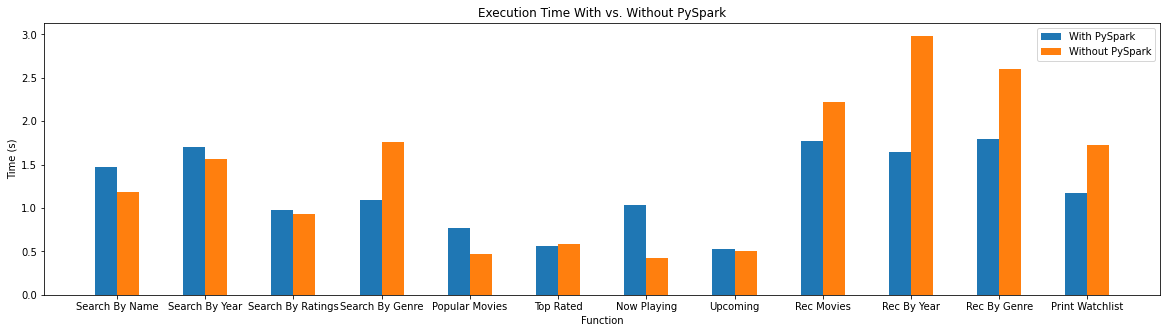

In [14]:
# Graph performance with PySpark vs. Without PySpark
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5) # make the plot bigger to fit all the bars
import numpy as np

funcs = np.arange(12)
times = np.array([1.4680063724517822, 1.6999092102050781, 0.9812173843383789, 1.0961816310882568,
                  0.7689945697784424, 0.5614702701568604, 1.0322275161743164, 0.527951717376709,
                  1.7734758853912354, 1.640211820602417, 1.795048713684082, 1.1739764213562012])
times2 = np.array([1.189316987991333, 1.5625107288360596, 0.9276401996612549, 1.7552893161773682,
                   0.4670743942260742, 0.5813198089599609, 0.42121148109436035, 0.5081536769866943,
                   2.222142219543457, 2.9816019535064697, 2.6054694652557373, 1.7224552631378174])

# Place two bars next to each other
plt.bar(funcs, times, width=0.25)
plt.bar(funcs + 0.25, times2, width=0.25)
plt.title("Execution Time With vs. Without PySpark")
plt.xlabel("Function")
plt.ylabel("Time (s)")
plt.xticks(funcs + 0.125,
           ["Search By Name", "Search By Year", "Search By Ratings", "Search By Genre",
            "Popular Movies", "Top Rated", "Now Playing", "Upcoming", "Rec Movies",
            "Rec By Year", "Rec By Genre", "Print Watchlist"])
plt.legend(["With PySpark", "Without PySpark"])
plt.show()